In [1]:
include("../sensor.jl") # To retrieve Sensor Positions
include("../doa/cbf.jl") # Conventional Beamformer
include("../doa/dbf_freeform.jl") # Differential Beamformer (coordinate-free) 
include("../doa/music.jl") # MUSIC

include("../utils/preprocess.jl")

sensors Loaded: (8,)
sensors1 Loaded: (25,)
sensors2 Loaded: (20,)
sensors_underwater loaded: (40,)


In [30]:
#=
Step 0: Open recording or generate signal
=#

# To Generate Signal:
include("../signal_generator/tone.jl")

freq = 50;          # Frequency of Tone (in Hz)
amp = 1;            # Amplitude of Tone
duration = 10;       # Duration of Tone (in seconds)
sample_rate = 32000.0;
tone_sig, n = tone(duration, amp, freq, sample_rate);

In [31]:
size(tone_sig)
typeof(tone_sig)

Matrix{Float64} (alias for Array{Float64, 2})

In [32]:
include("../signal_generator/generate_sig.jl")
using DSP.Windows: hanning, rect, bartlett
az_gt = -90.0;        # Ground Truth Azimuth Angle (in degrees)
az_gt2 = 120.0;
c0 = 343;          # Speed of Medium (in m/s)
NFFT = 2^11;
noverlap = Int(NFFT * (3 // 4));
sig1, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors,
                         NFFT, noverlap, rect, az_gt, c0);
sig2, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors, 
                        NFFT, noverlap, rect, az_gt2, c0); 
new_sig = sig1 + sig2;


Start Simulating Signal
Signal has size: (320000, 1)


Using STFT w/ NFFT=2048 & noverlap=1536


  1.218969 seconds (680.50 k allocations: 1.217 GiB, 17.57% gc time, 32.53% compilation time)
Now Generated Signal has size: (320000, 8)
Start Simulating Signal
Signal has size: (320000, 1)
Using STFT w/ NFFT=2048 & noverlap=1536


  0.760339 seconds (219.69 k allocations: 1.195 GiB, 26.00% gc time)
Now Generated Signal has size: (320000, 8)


In [33]:
# Add Noise
using Random
using DSP: db2amp
using SignalAnalysis: PinkGaussian
rng = Random.seed!(1234);
noise_pow = 0; # in dB
noise = rand(rng, size(new_sig,1), size(new_sig,2))
rng = Random.seed!(1234);
pink_noise = rand(rng, PinkGaussian(size(new_sig, 1), 2.0));
noisy_sig = new_sig + db2amp(noise_pow) .* noise;
noisy_sig1 = sig1 + db2amp(noise_pow) .* noise;
noisy_sig2 = sig2 + db2amp(noise_pow) .* noise;

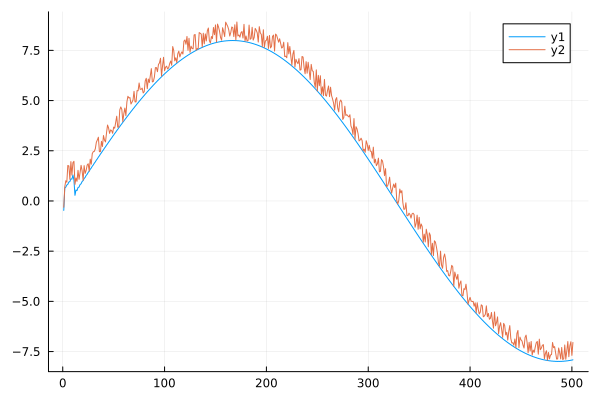

In [34]:
plot(new_sig[64000:64500,1])
plot!(noisy_sig[64000:64500,1])

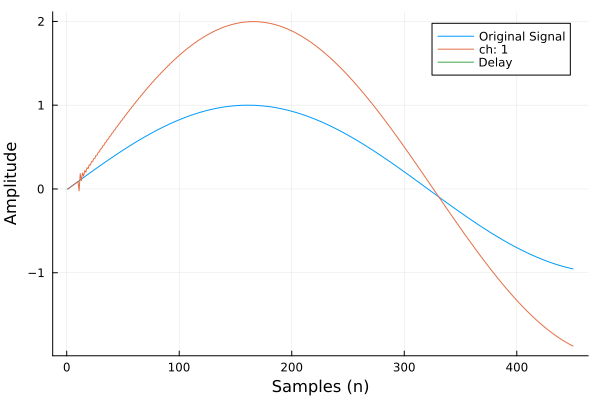

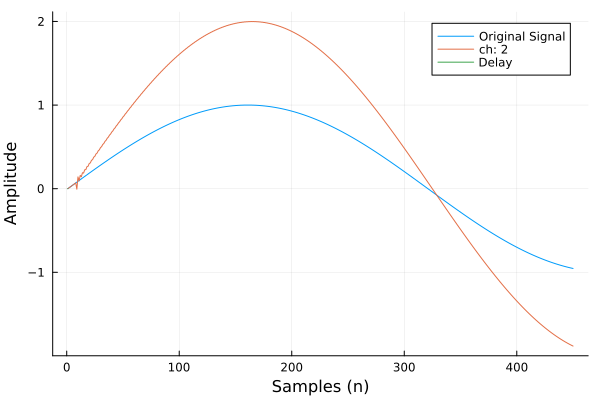

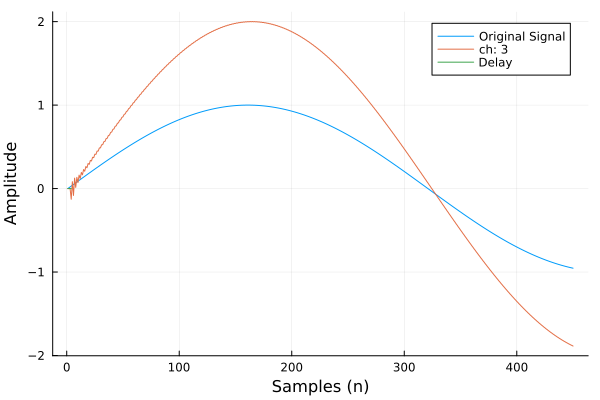

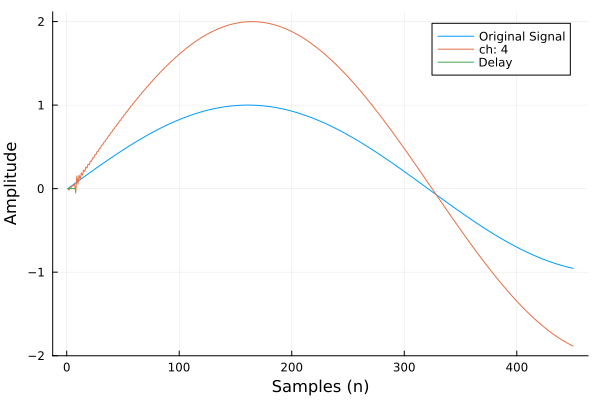

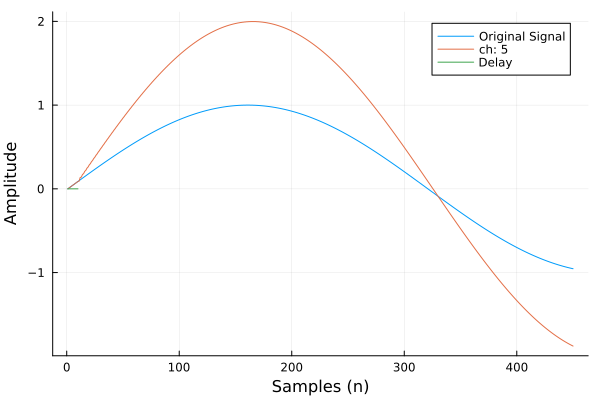

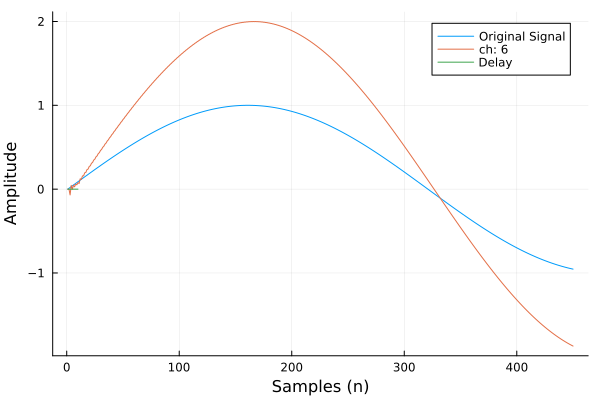

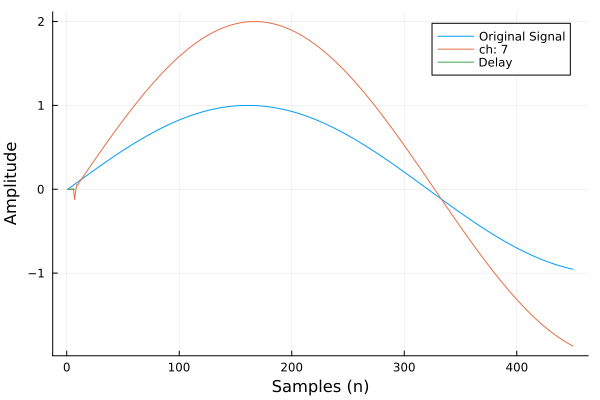

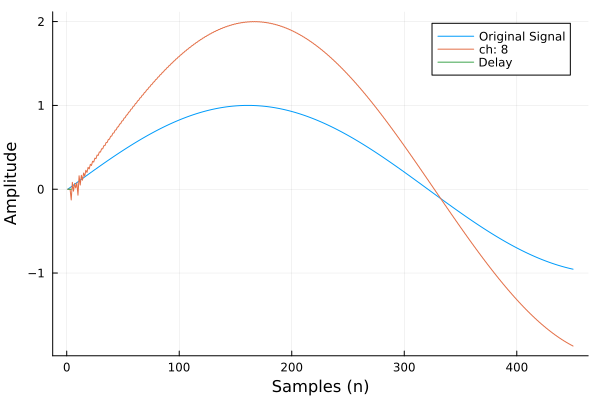

In [35]:
include("../utils/delay.jl")
using Plots
# Indicates Delay time at each sensor
delays = generate_time_delay.(sensors, az_gt, 90, c0);
delays .-= minimum(delays)
check_delayed_signal(tone_sig, new_sig, delays, 50)

In [36]:
include("../doa/cbf.jl")
include("../doa/dbf_freeform.jl")

function filter_freq_per_ch(new_sig)
    new_S = []
    for sig in eachcol(new_sig)
        S_interest = choose_freq(sig, freq, sample_rate);
        push!(new_S, S_interest);
    end
    # test_sig = Matrix{}(undef, size(new_sig, 2)) 
    new_S = mapreduce(permutedims, vcat, new_S);
    return new_S
end

new_S = filter_freq_per_ch(new_sig);
new_S1 = filter_freq_per_ch(sig1);
new_S2 = filter_freq_per_ch(sig2);

In [37]:
using Statistics
n_snapshots = 64;
Rx = cov(new_S[:,end-n_snapshots:end], dims=2);
order = 3;
@time P_cbf, az_list = cbf(Rx, sensors, freq, c0)
@time P_dbf, az_list = dbf_coFree(Rx, sensors, order, freq, c0)
Rx1 = cov(new_S1[:,end-n_snapshots:end], dims=2);
@time P1_cbf, az_list = cbf(Rx1, sensors, freq, c0)
@time P1_dbf, az_list = dbf_coFree(Rx1, sensors, order, freq, c0)
Rx2 = cov(new_S2[:,end-n_snapshots:end], dims=2);
@time P2_cbf, az_list = cbf(Rx2, sensors, freq, c0)
@time P2_dbf, az_list = dbf_coFree(Rx2, sensors, order, freq, c0)

  0.074344 seconds (301.18 k allocations: 15.449 MiB, 99.28% compilation time)


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.144305 seconds (207.96 k allocations: 10.753 MiB, 99.05% compilation time)
  0.000514 seconds (4.35 k allocations: 384.562 KiB)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.000977 seconds (11.47 k allocations: 683.195 KiB)
  0.000869 seconds (4.35 k allocations: 384.562 KiB)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.001075 seconds (11.47 k allocations: 683.492 KiB)


([143853.99782791504, 173746.72699871668, 209578.2888146658, 250536.77256602168, 295831.4648279897, 344667.49000764225, 396280.3360480739, 449916.9301946171, 504853.8130187126, 560396.8970554802  …  270956.43388899387, 212838.36200713576, 167286.92931602002, 133683.37373499805, 111375.8615968473, 99665.48924360507, 97822.44254262623, 105095.15578659209, 120702.317388909, 143854.45261513226], LinRange{Float64}(-180.0, 180.0, 361), ComplexF64[8.86038620601215e-7 - 2.1392916200798745e-6im 8.860386206012149e-7 + 2.1392916200798745e-6im … 2.1392916200798745e-6 + 8.86038620601215e-7im -2.1392916200798745e-6 + 8.86038620601215e-7im; 0.00020430071312039166 - 0.0002043099497548014im 0.0002043007131203916 + 0.00020430994975480143im … -0.00020430071312039166 + 0.0002043099497548014im -0.00020430071312039166 - 0.0002043099497548014im; … ; 0.00020430071312039166 + 0.0002043099497548014im 0.0002043007131203916 - 0.00020430994975480143im … -0.00020430071312039166 - 0.0002043099497548014im -0.00020430

In [38]:
function normalize_P(P, az_list) 
    (P_max, max_idx) = findmax(P);
    return (P ./ P_max), az_list[max_idx]
end

P_cbf_norm, az_cbf_max = normalize_P(P_cbf, az_list)
P_dbf_norm, az_dbf_max = normalize_P(P_dbf, az_list)
P1_cbf_norm, az1_cbf_max = normalize_P(P1_cbf, az_list)
P1_dbf_norm, az1_dbf_max = normalize_P(P1_dbf, az_list)
P2_cbf_norm, az2_cbf_max = normalize_P(P2_cbf, az_list)
P2_dbf_norm, az2_dbf_max = normalize_P(P2_dbf, az_list)

([0.011583680698609293, 0.01399075895262342, 0.01687605499774934, 0.020174190641101028, 0.023821494577221405, 0.027753960346765444, 0.03191002647983209, 0.036229052643412835, 0.040652783084137147, 0.045125327192835435  …  0.02181846080606374, 0.017138568709470038, 0.013470591040269066, 0.010764702680779944, 0.008968415461165767, 0.008025450953748672, 0.00787704169978895, 0.008462668719563717, 0.009719417780018067, 0.011583717319836298], 120.0)

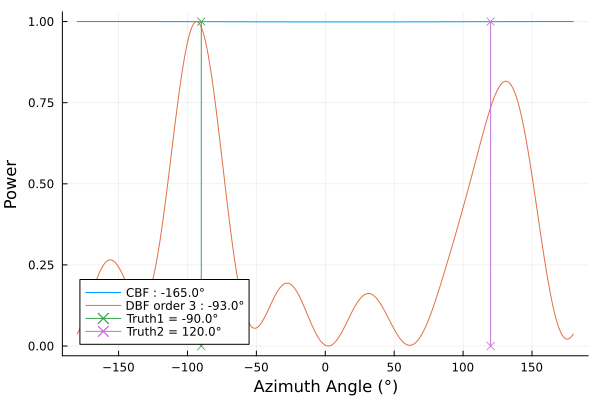

In [39]:
using Plots
plot(az_list, P_cbf_norm, label="CBF : $(az_cbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power");
plot!(az_list, P_dbf_norm, label="DBF order $order : $(az_dbf_max)°")
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°")


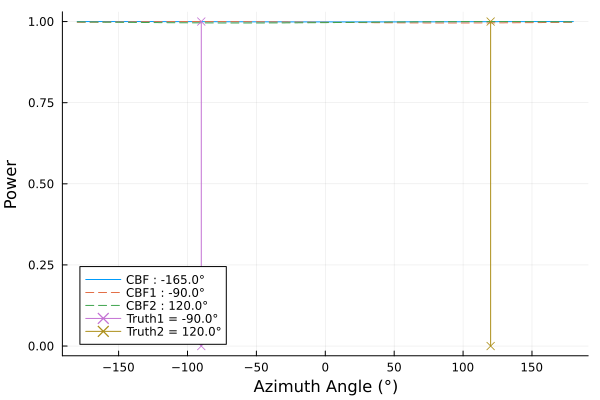

In [40]:
plot(az_list, P_cbf_norm, label="CBF : $(az_cbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power");
plot!(az_list, P1_cbf_norm, label="CBF1 : $(az1_cbf_max)°",
    linestyle=:dash);
plot!(az_list, P2_cbf_norm, label="CBF2 : $(az2_cbf_max)°",
    linestyle=:dash);
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°")

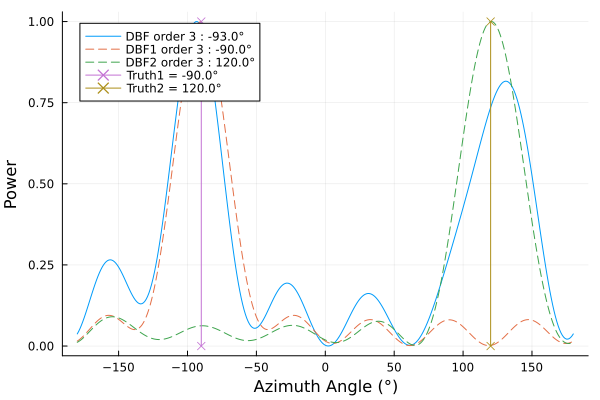

In [41]:
plot(az_list, P_dbf_norm, label="DBF order $order : $(az_dbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power");
plot!(az_list, P1_dbf_norm, label="DBF1 order $order : $(az1_dbf_max)°",
    linestyle=:dash);
plot!(az_list, P2_dbf_norm, label="DBF2 order $order : $(az2_dbf_max)°",
    linestyle=:dash);
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°")


In [42]:
max_snapshots

22

In [43]:
using Statistics: cov
#=
Prepate for TDoA
=#
corr_samples = 8;
max_snapshots = div(size(new_S, 2), corr_samples);
t_doa = 1:max_snapshots;
az = [];
P_cbfs = [];
P_dbfs = [];

doas_cbfs = [];
doas_dbfs = [];
doas_mdbfs = [];

order = 3;
dbf_filters = [];
covariances = [];

for t in t_doa
    start = (t-1) * corr_samples + 1;
    end_t = t * corr_samples;
    # Rx = cov(new_S[:, start:end_t], dims=2);
    Rx = (1 ./ corr_samples) .* new_S[:, start:end_t] * new_S[:, start:end_t]' ; 
    println("Start: $start, End: $end_t")
    push!(covariances, Rx)

    P_cbf, az_list = cbf(Rx, sensors, freq, c0);
    P_dbf, az_list, ___, dbf_filter = dbf_coFree(Rx, sensors, order, freq, c0);
    # P_mdbf, az_list = mdbf(Rx, sensors, order, freq, c0, wng_pow);
    
    __, az_cbf = predict_az(P_cbf, az_list);
    __, az_dbf = predict_az(P_dbf, az_list);
    # __, az_mdbf = predict_az(P_mdbfs, az_list);

    # println("Maximum CBF: $(maximum(P_cbf))")
    # println("Maximum DBF: $(maximum(P_dbf))")
    push!(doas_cbfs, az_cbf)
    push!(doas_dbfs, az_dbf)
    # push!(doas_mdbfs, az_mdbf)
    push!(P_cbfs, P_cbf)
    push!(P_dbfs, P_dbf)
    # push!(P_mdbfs, P_mdbf)
    if t == 1
        append!(az, az_list)
        # println("dbf_filter: $(dbf_filter)")
        push!(dbf_filters, dbf_filter)
    end
end

P_cbfs = mapreduce(permutedims, vcat, P_cbfs);
P_cbfs = P_cbfs';

P_dbfs = mapreduce(permutedims, vcat, P_dbfs);
P_dbfs = P_dbfs';

Start: 1, End: 8
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
Start: 9, End: 16
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
Start: 17, End: 24
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
Start: 25, End: 32
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
Start: 33, End: 40
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
Start: 41, End: 48
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
Start: 49, End: 56
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
Start: 57, End: 64
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
Start: 65, End: 72
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has

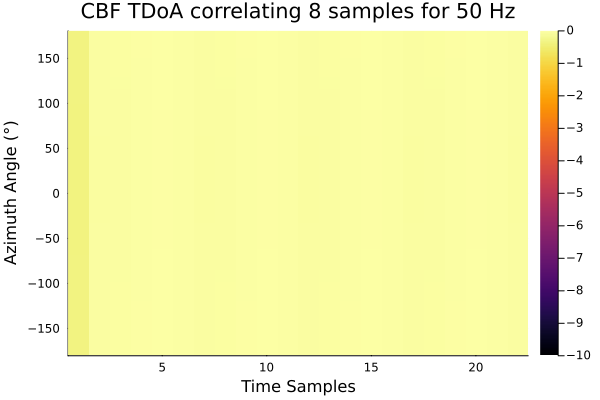

(361, 22)
  0.001066 seconds (1.36 k allocations: 179.242 KiB)


"/Users/odas2/Desktop/SoundMapping/doa_branch/localization/plots/cbf_multisnapshot_50Hz.png"

In [44]:
using Plots
using DSP.Util: pow2db
P_cbfs_db = pow2db.(P_cbfs);
P_cbfs_db .-= maximum(P_cbfs_db);
println(size(P_cbfs_db))
@time p = plot(t_doa, az, P_cbfs_db, st=:heatmap,
     clims=(-10.0, 0.0),
     xlabel="Time Samples",
     ylabel="Azimuth Angle (°)",
     title="CBF TDoA correlating $(corr_samples) samples for $(freq) Hz", rasterized = true)
display(p)
savefig("../plots/cbf_multisnapshot_$(freq)Hz.png")

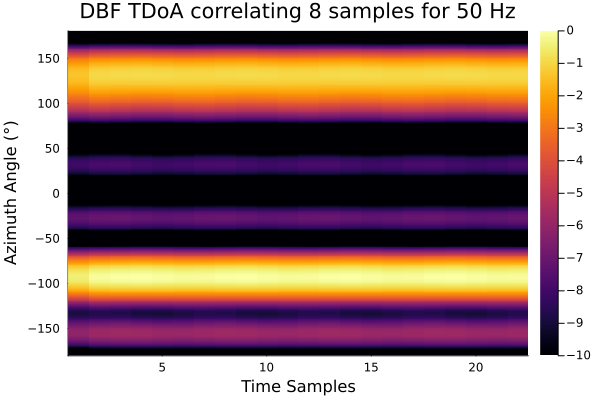

(361, 22)
  0.000986 seconds (1.36 k allocations: 179.242 KiB)


"/Users/odas2/Desktop/SoundMapping/doa_branch/localization/plots/dbf_multisnapshot_50Hz.png"

In [45]:
P_dbfs_db = pow2db.(P_dbfs);
P_dbfs_db .-= maximum(P_dbfs_db);
println(size(P_dbfs_db))
@time p = plot(t_doa, az, P_dbfs_db, st=:heatmap,
     clims=(-10.0, 0.0),
     xlabel="Time Samples",
     ylabel="Azimuth Angle (°)",
     title="DBF TDoA correlating $(corr_samples) samples for $(freq) Hz", rasterized = true)
display(p)
savefig("../plots/dbf_multisnapshot_$(freq)Hz.png")

In [226]:
noisy_S = filter_freq_per_ch(noisy_sig);
noisy_S1 = filter_freq_per_ch(noisy_sig1);
noisy_S2 = filter_freq_per_ch(noisy_sig2);

using Statistics
n_snapshots = 64;
noisy_Rx = cov(noisy_S[:,1:n_snapshots], dims=2);
order = 3;
@time Pn_cbf, az_list = cbf(noisy_Rx, sensors_underwater, freq, c0)
@time Pn_dbf, az_list = dbf_coFree(noisy_Rx, sensors_underwater, order, freq, c0)
noisy_Rx1 = cov(noisy_S1[:,1:n_snapshots], dims=2);
@time P1n_cbf, az_list = cbf(noisy_Rx1, sensors_underwater, freq, c0)
@time P1n_dbf, az_list = dbf_coFree(noisy_Rx1, sensors_underwater, order, freq, c0)
noisy_Rx2 = cov(noisy_S2[:,1:n_snapshots], dims=2);
@time P2n_cbf, az_list = cbf(noisy_Rx2, sensors_underwater, freq, c0)
@time P2n_dbf, az_list = dbf_coFree(noisy_Rx2, sensors_underwater, order, freq, c0)

  0.003715 seconds (15.90 k allocations: 1.631 MiB)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.002169 seconds (13.36 k allocations: 1.106 MiB)
  0.002615 seconds (15.90 k allocations: 1.631 MiB)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.001670 seconds (13.36 k allocations: 1.105 MiB)
  0.002575 seconds (15.90 k allocations: 1.631 MiB)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.001671 seconds (13.36 k allocations: 1.105 MiB)


([222512.02531962463, 230062.58754971414, 237955.53210270504, 246070.20351752714, 254288.8180287853, 262497.4421073363, 270586.9177191022, 278453.7265030954, 286000.78572323476, 293138.16957364517  …  189931.2870555442, 189023.335740248, 189496.58899511094, 191252.89250268767, 194187.2725649342, 198188.9734478718, 203142.52800394315, 208928.85158664754, 215426.34914031238, 222512.0253196009], LinRange{Float64}(-180.0, 180.0, 361), ComplexF64[0.0 + 2.3908203039040495e-5im 0.0 + 0.00019087261959543656im … -0.000202821959874734 - 0.000947628789081802im -0.0007655650718008316 - 0.00024881805381223124im; -0.0013695261293235575 + 0.0im -0.005463097987779859 + 0.0im … 0.006009700956152899 - 0.014914890292374024im -0.004392940862485556 - 0.01352265060754891im; … ; -0.0013695261293235575 + 0.0im -0.005463097987779859 + 0.0im … 0.006009700956152899 + 0.014914890292374024im -0.004392940862485556 + 0.01352265060754891im; 0.0 + 2.3908203039040495e-5im 0.0 + 0.00019087261959543656im … 0.000202821959

In [227]:
Pn_cbf_norm, n_az_cbf_max = normalize_P(Pn_cbf, az_list)
Pn_dbf_norm, n_az_dbf_max = normalize_P(Pn_dbf, az_list)
P1n_cbf_norm, n_az1_cbf_max = normalize_P(P1n_cbf, az_list)
P1n_dbf_norm, n_az1_dbf_max = normalize_P(P1n_dbf, az_list)
P2n_cbf_norm, n_az2_cbf_max = normalize_P(P2n_cbf, az_list)
P2n_dbf_norm, n_az2_dbf_max = normalize_P(P2n_dbf, az_list)

([0.18471711051070688, 0.19098516742075472, 0.19753745109690854, 0.20427380008450444, 0.21109643685094565, 0.2179107801156772, 0.224626212948603, 0.2311568001626295, 0.2374219490686036, 0.2433470082628642  …  0.15767039327463048, 0.1569166625798287, 0.15730953111649543, 0.158767516628215, 0.1612034757879944, 0.16452546534412105, 0.16863763089131023, 0.1734411149778076, 0.17883497614975705, 0.18471711051068718], 124.0)

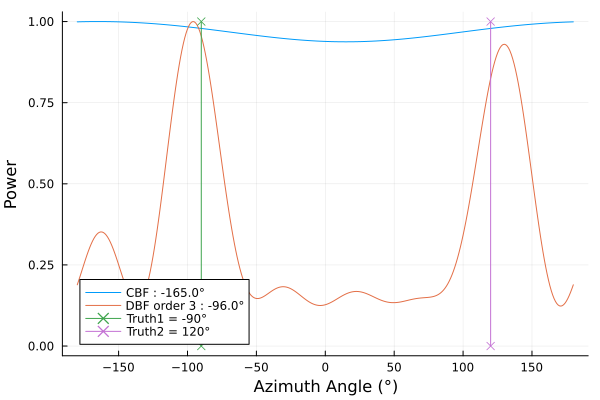

In [231]:
plot(az_list, Pn_cbf_norm, label="CBF : $(n_az_cbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power");
plot!(az_list, Pn_dbf_norm, label="DBF order $order : $(n_az_dbf_max)°")
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°")

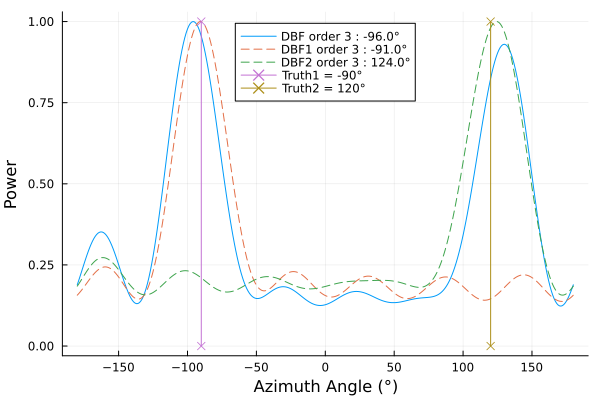

In [232]:
plot(az_list, Pn_dbf_norm, label="DBF order $order : $(n_az_dbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power");
plot!(az_list, P1n_dbf_norm, label="DBF1 order $order : $(n_az1_dbf_max)°",
    linestyle=:dash);
plot!(az_list, P2n_dbf_norm, label="DBF2 order $order : $(n_az2_dbf_max)°",
    linestyle=:dash);
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°", legend=:top)

weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


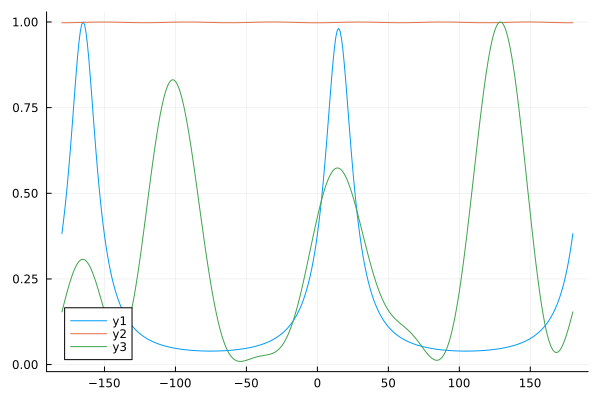

In [229]:
include("./doa/music.jl")
eig_values, Rs, Rn = get_eigensubspace(Rx, 2)
P_music, az_list = cbf(Rn, sensors_underwater, freq, c0);
P_dbf_music, az_list = dbf_coFree(Rn, sensors_underwater, order, freq, c0)

P_music_norm, az_music_max = normalize_P(1 ./ P_music, az_list)
P_dbfmusic_norm, az_dbfmusic_max = normalize_P(1 ./ P_dbf_music, az_list)
plot(az_list, P_music_norm)
plot!(az_list, P_dbfmusic_norm)
plot!(az_list, P_dbf_norm)
# println(eig_values)

weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


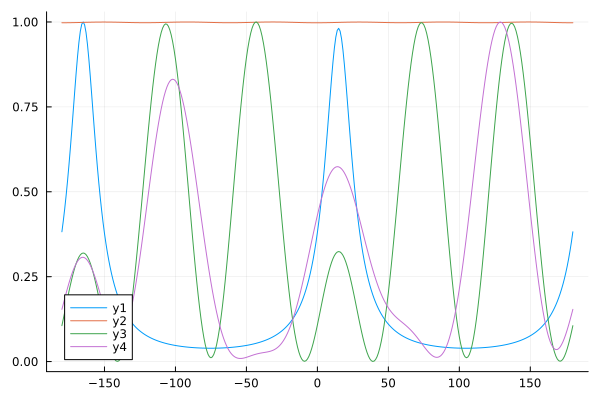

In [230]:
P_music, az_list = cbf(Rn, sensors_underwater, freq, c0);
P_dbf_music, az_list = dbf_coFree(Rn, sensors_underwater, order, freq, c0)
P_dbf_rs, az_list = dbf_coFree(Rs, sensors_underwater, order, freq, c0)

P_music_norm, az_music_max = normalize_P(1 ./ P_music, az_list)
P_dbfmusic_norm, az_dbfmusic_max = normalize_P(1 ./ P_dbf_music, az_list)
P_dbfrs_norm, az_dbfrs_max = normalize_P(P_dbf_rs, az_list)
plot(az_list, P_music_norm)
plot!(az_list, P_dbfmusic_norm)
plot!(az_list, P_dbfrs_norm)
plot!(az_list, P_dbf_norm)

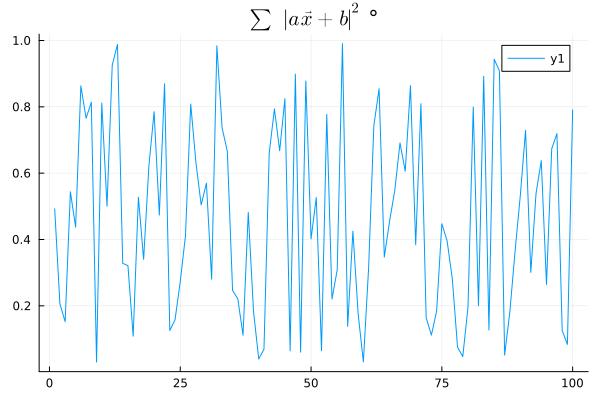

In [160]:
using Plots, LaTeXStrings
plot(rand(100))
title!(L"$\sum |a\vec{x} + b|^{2}$ °")

In [ ]:
wavwrite()

1000-element Vector{Float64}:
 0.5798621201341324
 0.4112941179498505
 0.9721360824554687
 0.014908849285099945
 0.520354993723718
 0.6395615996802734
 0.8396219340580711
 0.967142768915383
 0.7897644095351307
 0.6960406981439002
 ⋮
 0.7938000916760949
 0.10667797515891897
 0.523289210236778
 0.21040115028811368
 0.6784581857267311
 0.4242946548331029
 0.48155359118450025
 0.4015278156986538
 0.5898496301286759